<a href="https://colab.research.google.com/github/elianderlohr/muse-dlf/blob/main/notebooks/explainablity/muse-dlf-explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MuSE-DLF Explainability

Plot the explainability of the MuSE-DLF model. By using the dictionary learning approach it is (1.) possible to extract how different words in a certaim semantic role predict the presence of a document level frame and (2.) identify how the FrameAxis constallations are predicting the document level frames.

In [1]:
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/Git/muse-dlf

assets		       data		     run	  used_labels_a0.npy
category_lists_a0.pkl  notebooks	     src	  used_labels_a1.npy
category_lists_a1.pkl  predicted_labels.npy  tests	  used_labels_p.npy
category_lists_fx.pkl  README.md	     ToDo.md
category_lists_p.pkl   research-notebooks    used_fx.npy


In [4]:
!pip install wandb==0.17.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
!pip install wandb==0.17.4 allennlp allennlp-models spacy

  Using cached torch-1.12.1-cp310-cp310-manylinux1_x86_64.whl (776.3 MB)
INFO: pip is looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
  Using cached allennlp-2.10.0-py3-none-any.whl (729 kB)
  Using cached torch-1.11.0-cp310-cp310-manylinux1_x86_64.whl (750.6 MB)
  Using cached torchvision-0.12.0-cp310-cp310-manylinux1_x86_64.whl (21.0 MB)
  Using cached allennlp-2.9.3-py3-none-any.whl (719 kB)
  Using cached spacy-3.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.1 MB)
  Using cached transformers-4.18.0-py3-none-any.whl (4.0 MB)
  Using cached filelock-3.6.0-py3-none-any.whl (10.0 kB)
  Using cached allennlp-2.9.2-py3-none-any.whl (719 kB)
  Using cached transformers-4.17.0-py3-none-any.whl (3.8 MB)
  Using cached allennlp-2.9.1-py3-none-any.whl (718 kB)
  Using cached allennlp-2.9.0-py3-none-any.whl (716 kB)
  Using cached allennlp-2.8.0-py3-none-any.whl (738 kB)
  Using cached allen

In [5]:
!pip install torch==2.3.1

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [6]:
!pip install iterative-stratification

In [9]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
import sys
sys.path.append('/content/drive/MyDrive/Git/muse-dlf/src')

In [25]:
from preprocessing.pre_processor import PreProcessor
from preprocessing.datasets.article_dataset import custom_collate_fn
from model.muse_dlf.muse import MuSEDLF
from model.slmuse_dlf.muse import SLMuSEDLF

# import tokenizer for roberta fast
from transformers import RobertaTokenizerFast
import wandb
import inspect
import torch
import spacy
import pickle
from pathlib import Path
from torch.utils.data import DataLoader

In [10]:
wandb.require("core")

In [11]:
import nltk

In [12]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [14]:
base_path = "drive/MyDrive/Git/"

## Setup wandb

In [15]:
from google.colab import userdata

wandb.login(key=userdata.get('WANDB_API_KEY'))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [16]:
run = wandb.init(project="muse-dlf", job_type="inference")

wandb: Currently logged in as: elias-anderlohr (elianderlohr). Use `wandb login --relogin` to force relogin


## Clean

In [17]:
def clean_gpu_memory():
    # Clear cache
    torch.cuda.empty_cache()
    # Reset peak memory stats
    torch.cuda.reset_peak_memory_stats()
    # Perform garbage collection
    import gc
    gc.collect()

clean_gpu_memory()

## Load MuSE-DLF

## Load Roberta Model

In [20]:
roberta_artifact = run.use_artifact('elianderlohr-org/wandb-registry-model/semeval-roberta-finetune:v1', type='model')
roberta_dir = roberta_artifact.download()

wandb: Downloading large artifact semeval-roberta-finetune:v1, 1427.27MB. 7 files... 
Done. 0:0:0.3


## Load Datasets

### Load Dev Dataset

In [ ]:
dataset_dev_artifact = run.use_artifact('elianderlohr-org/wandb-registry-dataset/semeval-dev:v0', type='dataset')
dataset_dev_dir = dataset_dev_artifact.download()

### Load Train Dataset

In [ ]:
dataset_train_artifact = run.use_artifact('elianderlohr-org/wandb-registry-dataset/semeval-train:v0', type='dataset')
dataset_train_dir = dataset_train_artifact.download()

### Load Test Dataset

In [21]:
dataset_test_artifact = run.use_artifact('elianderlohr-org/wandb-registry-dataset/semeval-test:v0', type='dataset')
dataset_test_dir = dataset_test_artifact.download()

## Load Model

In [188]:
import inspect
def load_model_from_wandb(name):
    model_artifact = run.use_artifact(name, type='model')
    model_dir = model_artifact.download()

    # Access the configuration
    config = model_artifact.metadata
    # Get the parameters of the SLMUSEDLF class constructor
    params = inspect.signature(SLMuSEDLF.__init__).parameters

    # Extract the relevant parameters from the config dictionary
    model_params = {key: config[key] for key in params if key in config}
    model_params["bert_model_name"] = "roberta-base"
    model_params["bert_model_name_or_path"] = roberta_dir
    # model_params["_debug"] = True

    model = SLMuSEDLF(**model_params)
    model.set_log_level("INFO")

    # Assuming you load the state_dict as follows
    state_dict = torch.load(f"{model_dir}/pytorch_model.bin", map_location="cuda")
    model.load_state_dict(state_dict)

    return model

name = 'elianderlohr/muse-dlf/train_freezing_gloves_6744_model:v14'
model = load_model_from_wandb(name)

wandb: Downloading large artifact train_freezing_gloves_6744_model:v14, 574.90MB. 2 files... 
Done. 0:0:0.4
Some weights of RobertaModel were not initialized from the model checkpoint at /content/artifacts/roberta-base-finetune-checkpoint-16482:v0 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:model.slmuse_dlf.muse:🔄 Using alternative supervised module 2


## Create Dataset

In [189]:
!ls drive/MyDrive/Git/muse-dlf/data/axis

732_semaxis_axes.tsv  mft_experiment.json  mft_raw.csv
custom.tsv	      mft_filtered.csv	   plutchik_wheel_of_emotions.tsv
frames.json	      mft.json		   wordnet_antonyms.tsv


In [190]:
class_column_names = "Capacity_and_resources;Crime_and_punishment;Cultural_identity;Economic;External_regulation_and_reputation;Fairness_and_equality;Health_and_safety;Legality_Constitutionality_and_jurisprudence;Morality;Policy_prescription_and_evaluation;Political;Public_opinion;Quality_of_life;Security_and_defense".split(";")

### Create Full Dataset

### Create Dev Dataset

In [ ]:
# Define paths to the dataset files within the downloaded directory
dev_artifact_filepath = Path(dataset_dev_dir) / 'dataset_artifact.pkl'

# Load the datasets from the artifact files
with dev_artifact_filepath.open("rb") as f:
    loaded_dev_dataset = pickle.load(f)

### Create Train Dataset

In [ ]:
# Define paths to the dataset files within the downloaded directory
train_artifact_filepath = Path(dataset_train_dir) / 'dataset_artifact.pkl'

# Load the datasets from the artifact files
with train_artifact_filepath.open("rb") as f:
    loaded_train_dataset = pickle.load(f)

### Create Test Dataset

In [34]:
# Define paths to the dataset files within the downloaded directory
test_artifact_filepath = Path(dataset_test_dir) / 'dataset_artifact.pkl'

# Load the datasets from the artifact files
with test_artifact_filepath.open("rb") as f:
    loaded_test_dataset = pickle.load(f)

In [35]:
test_dataset, test_df = loaded_test_dataset

In [36]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    collate_fn=custom_collate_fn,
    drop_last=False,
    pin_memory=True,
    num_workers=1,
)

### Create Example Dataset

In [ ]:
preprocessor = PreProcessor(
    tokenizer=tokenizer,
    batch_size=config["batch_size"],
    max_sentences_per_article=config["num_sentences"],
    max_sentence_length=config["max_sentence_length"],
    max_args_per_sentence=config["max_args_per_sentence"],
    max_arg_length=config["max_arg_length"],
    frameaxis_dim=config["frameaxis_dim"],
    bert_model_name="roberta-base",
    name_tokenizer="roberta-base",
    path_name_bert_model=roberta_dir,
    path_antonym_pairs=f"{base_path}muse-dlf/data/axis/mft.json",
    dim_names=["virtue", "vice"],
    class_column_names=class_column_names,
    )

In [ ]:
text = "BILL ON IMMIGRANT WORKERS DIES. Legislation to allow nearly twice as many computer-savvy foreigners and other high-skilled immigrants into the country next year apparently has died in Congress. The House passed the compromise measure last month, 288-133, but Sen. Tom Harkin, D-Iowa, had blocked a vote when in the Senate. The proposal, backed by high-tech companies, would raise the limit of so- called H-1B visas granted each year to skilled workers from abroad. Only 65,000 visas are now granted each year; the bill would raise the annual cap to 115,500 for the next two years and to 107,500 in 2001. The ceiling would return to 65,000 in 2002."

In [ ]:
example_dataset, example_dataloader = preprocessor.preprocess_single_article(
    text
)

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that yo

## Run model with data

In [191]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
Tesla T4


In [192]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [193]:
from tqdm.notebook import tqdm
import numpy as np
import torch

def inspect(model, dataloader, device='cuda'):
    """
    Make predictions with the given model and dataloader.

    Args:
    - model (torch.nn.Module): The model to make predictions with.
    - dataloader (DataLoader): DataLoader for the dataset to predict on.
    - device (str): Device to make predictions on ('cpu' or 'cuda').

    Returns:
    - predicted_labels (list of lists): List containing the predicted labels for each instance.
    """
    model = model.to("cuda")
    model.eval()

    # dim
    batch_size = dataloader.batch_size
    num_sentences = 32 # dataloader.dataset.max_sentences_per_article
    max_args_per_sentence = 10 #dataloader.dataset.max_args_per_sentence
    K = 14

    print("num_batches", len(dataloader))
    print("batch_size", batch_size)
    print("num_sentences", num_sentences)
    print("max_args_per_sentence", max_args_per_sentence)
    print("K", K)

    all_preds_span = []

    # Initialize usage lists for each label
    all_used_labels_p = []
    all_used_labels_a0 = []
    all_used_labels_a1 = []

    all_used_fx = []

    with torch.no_grad():
        # Wrap the dataloader with tqdm for batch progress
        for batch in tqdm(dataloader, desc="Processing Batches"):
            sentence_ids = batch['sentence_ids'].to(device)
            sentence_attention_masks = batch['sentence_attention_masks'].to(device)

            predicate_ids = batch['predicate_ids'].to(device)
            arg0_ids = batch['arg0_ids'].to(device)
            arg1_ids = batch['arg1_ids'].to(device)

            frameaxis_data = batch['frameaxis'].to(device)

            sentence_embeddings, predicate_embeddings, arg0_embeddings, arg1_embeddings = model.aggregation(sentence_ids, sentence_attention_masks, predicate_ids, arg0_ids, arg1_ids)

            # Process each span
            for sentence_idx in range(sentence_embeddings.size(1)):
                s_sentence_span = sentence_embeddings[:, sentence_idx, :]
                v_fx = frameaxis_data[:, sentence_idx, :]

                for span_idx in range(predicate_embeddings.size(2)):
                    v_p_span = predicate_embeddings[:, sentence_idx, span_idx, :]
                    v_a0_span = arg0_embeddings[:, sentence_idx, span_idx, :]
                    v_a1_span = arg1_embeddings[:, sentence_idx, span_idx, :]

                    mask_p = (v_p_span.abs().sum(dim=-1) != 0).float().bool()
                    mask_a0 = (v_a0_span.abs().sum(dim=-1) != 0).float().bool()
                    mask_a1 = (v_a1_span.abs().sum(dim=-1) != 0).float().bool()

                    output = model.unsupervised.combined_autoencoder(
                        v_p_span, v_a0_span, v_a1_span, mask_p, mask_a0, mask_a1, s_sentence_span, 0.6
                    )

                    all_used_labels_p.append(output["p"]["d"].cpu().numpy())
                    all_used_labels_a0.append(output["a0"]["d"].cpu().numpy())
                    all_used_labels_a1.append(output["a1"]["d"].cpu().numpy())

                    del v_p_span, v_a0_span, v_a1_span, mask_p, mask_a0, mask_a1, output
                    torch.cuda.empty_cache()

                mask_fx = (v_fx.abs().sum(dim=-1) != 0).float().bool()

                frameaxis_output = model.unsupervised_fx.frameaxis_autoencoder(v_fx, mask_fx, s_sentence_span, 0.6)

                all_used_fx.append(frameaxis_output["d"].cpu().numpy())

                del v_fx, mask_fx, frameaxis_output
                torch.cuda.empty_cache()

            # Forward pass
            outputs = model(
                sentence_ids, sentence_attention_masks, predicate_ids, arg0_ids, arg1_ids, frameaxis_data, 0.5
            )

            supervised_logits = outputs["supervised_logits"]

            combined_pred = (torch.sigmoid(supervised_logits) > 0.5).long()

            all_preds_span.append(combined_pred.cpu().numpy())

            del sentence_ids, sentence_attention_masks, predicate_ids, arg0_ids, arg1_ids, frameaxis_data
            del sentence_embeddings, predicate_embeddings, arg0_embeddings, arg1_embeddings
            del supervised_logits, combined_pred
            torch.cuda.empty_cache()

    predictions = np.vstack(all_preds_span)

    all_used_labels_p = np.vstack(all_used_labels_p)
    all_used_labels_a0 = np.vstack(all_used_labels_a0)
    all_used_labels_a1 = np.vstack(all_used_labels_a1)

    all_used_fx = np.vstack(all_used_fx)

    # reshape from (iterator (1), num sentences 24, num spans 10, batch size 64, classes 15) to (batch size 64, num sentences 24, num spans 10, classes 15)
    all_used_labels_p = all_used_labels_p.reshape(-1, num_sentences, max_args_per_sentence, K)
    all_used_labels_a0 = all_used_labels_a0.reshape(-1, num_sentences, max_args_per_sentence, K)
    all_used_labels_a1 = all_used_labels_a1.reshape(-1, num_sentences, max_args_per_sentence, K)

    all_used_fx = all_used_fx.reshape(-1, num_sentences, K)

    return predictions, all_used_labels_p, all_used_labels_a0, all_used_labels_a1, all_used_fx


In [194]:
clean_gpu_memory()

In [195]:
output = inspect(model, test_dataloader, device="cuda")

num_batches 7
batch_size 8
num_sentences 32
max_args_per_sentence 10
K 14


Processing Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [196]:
predicted_labels, used_labels_p, used_labels_a0, used_labels_a1, used_fx = output

In [197]:
predicted_labels

array([[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 1,

### Create Output which can be validated with semeval validator

In [198]:
article_ids = test_df["article_id"]

In [199]:
id_order = [
    '311', '3132', '3138', '3154', '3126', '3131', '313', '3119', '3116', '3125',
    '3147', '3113', '3121', '3143', '3114', '316', '3110', '3151', '3146', '3141',
    '317', '3115', '314', '3122', '3112', '3140', '3118', '3124', '3134', '3127',
    '3120', '318', '3135', '3130', '3133', '3144', '3142', '3123', '3111', '3153',
    '3148', '315', '3150', '3129', '3137', '3117', '312', '3149', '3136', '3152',
    '3139', '3145', '3128'
]

In [200]:
# Create a dictionary for quick lookup of sort order
id_order_dict = {id: index for index, id in enumerate(id_order)}

# Match predictions with column names and create the output
output = []
for article_id, row in zip(article_ids, predicted_labels):
    labels = [class_column_names[i] for i, val in enumerate(row) if val == 1]
    output.append((article_id, f"{article_id}\t{','.join(labels)}"))

# Sort the output based on the custom ID order
sorted_output = sorted(output, key=lambda x: id_order_dict.get(x[0], len(id_order)))

# Extract just the formatted strings from the sorted output
sorted_output_strings = [item[1] for item in sorted_output]

# Save the sorted data to a CSV file
with open('output_sorted.csv', 'w') as f:
    f.write('\n'.join(sorted_output_strings))

print("Sorted output has been saved to 'output_sorted.csv'")

Sorted output has been saved to 'output_sorted.csv'


## Evaluate Predictions

### Extract Semantic Roles

In [ ]:
import numpy as np
# Load arrays from .npy files (for verification or later use)
predicted_labels = np.load(base_path + 'muse-dlf/predicted_labels.npy')
used_labels_p = np.load(base_path + 'muse-dlf/used_labels_p.npy')
used_labels_a0 = np.load(base_path + 'muse-dlf/used_labels_a0.npy')
used_labels_a1 = np.load(base_path + 'muse-dlf/used_labels_a1.npy')
used_fx = np.load(base_path + 'muse-dlf/used_fx.npy')

In [ ]:
test_dataloader.dataset[0]["sentence_ids"]

tensor([[    0, 23031,  8072,  ...,     1,     1,     1],
        [    0, 20028, 17444,  ...,     1,     1,     1],
        [    0, 39594,    35,  ...,     1,     1,     1],
        ...,
        [    0,  1121,  1285,  ...,     1,     1,     1],
        [    0, 10105,     9,  ...,     1,     1,     1],
        [    0,   845,     2,  ...,     1,     1,     1]])

In [ ]:
import pandas as pd

# Count occurrences of each class prediction
class_counts = np.sum(predicted_labels, axis=0)

# Create a table with class names and counts
class_counts_table = pd.DataFrame({
    'Class Name': class_column_names,
    'Count': class_counts
})

# Display the table
class_counts_table.sort_values(by='Count', ascending=False, inplace=True)
print(class_counts_table)

                                   Class Name  Count
11                                  Political  231.0
1                        Crime and Punishment  165.0
7   Legality, Constitutionality, Jurisdiction  162.0
3                                    Economic  113.0
2                           Cultural Identity   69.0
13                            Quality of Life   40.0
12                           Public Sentiment   35.0
10         Policy Prescription and Evaluation   34.0
14                       Security and Defense   31.0
5                       Fairness and Equality   30.0
4          External Regulation and Reputation   25.0
6                           Health and Safety   24.0
0                      Capacity and Resources   11.0
8                                    Morality    7.0
9                                       Other    0.0


In [ ]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np

# Initialize category lists
category_lists_p = {category: [] for category in class_column_names}
category_lists_a1 = {category: [] for category in class_column_names}
category_lists_a0 = {category: [] for category in class_column_names}
category_lists_fx = {category: [] for category in class_column_names}

counter = 0

elem_len = len(test_dataloader.dataset)
for elem_idx in tqdm(range(elem_len), desc="Elements"):
    ds = test_dataloader.dataset[elem_idx]

    sent_len = len(ds["predicate_ids"])
    for sentence_idx in tqdm(range(sent_len), desc="Sentences", leave=False):
        span_len = len(ds["predicate_ids"][sentence_idx])
        for span_idx in tqdm(range(span_len), desc="Spans", leave=False):

            # Processing p
            p = used_labels_p[elem_idx][sentence_idx][span_idx]
            max_p = np.max(p)
            if max_p > 0.5:
                argmax_p = np.argmax(p)
                ds_p_value = ds["predicate_ids"][sentence_idx][span_idx].int().numpy()
                if not np.all(p == p[0]) and not np.all(ds_p_value == 0):
                    category_lists_p[class_column_names[argmax_p]].append(ds_p_value)

            # Processing a0
            a0 = used_labels_a0[elem_idx][sentence_idx][span_idx]
            max_a0 = np.max(a0)
            if max_a0 > 0.5:
                argmax_a0 = np.argmax(a0)
                ds_a0_value = ds["arg0_ids"][sentence_idx][span_idx].int().numpy()
                if not np.all(a0 == a0[0]) and not np.all(ds_a0_value == 0):
                    category_lists_a0[class_column_names[argmax_a0]].append(ds_a0_value)

            # Processing a1
            a1 = used_labels_a1[elem_idx][sentence_idx][span_idx]
            max_a1 = np.max(a1)
            if max_a1 > 0.5:
                argmax_a1 = np.argmax(a1)
                ds_a1_value = ds["arg1_ids"][sentence_idx][span_idx].int().numpy()
                if not np.all(a1 == a1[0]) and not np.all(ds_a1_value == 0):
                    category_lists_a1[class_column_names[argmax_a1]].append(ds_a1_value)

        # Processing fx
        fx = used_fx[elem_idx][sentence_idx]
        max_fx = np.max(fx)
        if max_fx > 0.5:
            argmax_fx = np.argmax(fx)
            if not np.all(fx == fx[0]):
                category_lists_fx[class_column_names[argmax_fx]].append(ds["frameaxis"][sentence_idx].float().numpy())

    counter += 1
    if counter == 20:
        break

print("Completed processing all elements.")


Elements:   0%|          | 0/1187 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Sentences:   0%|          | 0/32 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Spans:   0%|          | 0/10 [00:00<?, ?it/s]

Completed processing all elements.


In [ ]:
# Function to save a dictionary using pickle
def save_dict_to_pickle(dictionary, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dictionary, f, protocol=pickle.HIGHEST_PROTOCOL)

# Save the dictionaries
save_dict_to_pickle(category_lists_p, base_path + 'muse-dlf/category_lists_p.pkl')
save_dict_to_pickle(category_lists_a0, base_path + 'muse-dlf/category_lists_a0.pkl')
save_dict_to_pickle(category_lists_a1, base_path + 'muse-dlf/category_lists_a1.pkl')
save_dict_to_pickle(category_lists_fx, base_path + 'muse-dlf/category_lists_fx.pkl')

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Ensure you have downloaded the necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def decode_tokens(token_dict, tokenizer, remove_stopwords=False, lemmatize=False):
    decoded_data = {}
    stop_words = set(stopwords.words('english')) if remove_stopwords else set()
    lemmatizer = WordNetLemmatizer() if lemmatize else None

    for category, token_lists in token_dict.items():
        decoded_data[category] = []
        for tokens in token_lists:
            if np.any(tokens > 0):
                # Convert tokens to a list if it's a tensor or numpy array
                if isinstance(tokens, torch.Tensor):
                    tokens = tokens.tolist()
                elif isinstance(tokens, np.ndarray):
                    tokens = tokens.tolist()

                # Decode the tokens
                decoded_text = tokenizer.decode(tokens, skip_special_tokens=True).strip()

                # Remove non-alphabetic characters (but keep spaces)
                decoded_text = re.sub(r'[^A-Za-z ]', '', decoded_text)

                # Tokenize, optionally lemmatize, and remove stop words
                words = word_tokenize(decoded_text)
                processed_words = [lemmatizer.lemmatize(word.lower()) if lemmatizer else word.lower() for word in words if word.lower() not in stop_words]

                # Join the words back into a string and ensure it's not empty
                processed_text = ' '.join(processed_words)
                if processed_text:
                    decoded_data[category].append(processed_text)

    return decoded_data

stop_words = set(stopwords.words('english'))

# Decode the token IDs for each ARG
decoded_predicate = decode_tokens(category_lists_p, tokenizer, remove_stopwords=True, lemmatize=True)
decoded_arg0 = decode_tokens(category_lists_a0, tokenizer, remove_stopwords=True, lemmatize=True)
decoded_arg1 = decode_tokens(category_lists_a1, tokenizer, remove_stopwords=True, lemmatize=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### IDF

In [ ]:
import math
from collections import Counter

def calculate_idf_per_category(data_dict):
    """
    Calculate the inverse document frequency (IDF) for each word in each category in the data_dict.
    Returns a dictionary with the same keys as the input, where the values are sorted lists of tuples (word, IDF score).
    """
    category_idfs = {}

    for category, documents in data_dict.items():
        word_counts = {}
        # Total number of documents in the current category
        N = len(documents)

        # Count the frequency of each word in the current category
        for doc in documents:
            unique_words = set(doc.split())
            for word in unique_words:
                word_counts[word] = word_counts.get(word, 0) + 1

        # Calculate IDF for each word in the current category
        idfs = {word: math.log(N / (1 + count)) for word, count in word_counts.items()}

        # Sort the idfs by score
        sorted_idfs = sorted(idfs.items(), key=lambda x: x[1], reverse=True)

        category_idfs[category] = sorted_idfs

    return category_idfs


# Calculate IDF scores for each category
idf_predicate = calculate_idf_per_category(decoded_predicate)
idf_arg0 = calculate_idf_per_category(decoded_arg0)
idf_arg1 = calculate_idf_per_category(decoded_arg1)

In [ ]:
import pandas as pd

def create_dataframe_with_limit(decoded_predicate, decoded_arg0, decoded_arg1, word_limit):
    # Initialize a list to collect DataFrame rows
    rows = []

    # Populate the list with rows
    for frame in set(decoded_predicate) | set(decoded_arg0) | set(decoded_arg1):
        # Get the lists, limiting the number of words and joining them with a comma
        pred_words = ', '.join([s.strip() for s in list(set(decoded_predicate.get(frame, [])))[:word_limit] if s])
        arg0_words = ', '.join(list(set(decoded_arg0.get(frame, [])))[:word_limit])
        arg1_words = ', '.join(list(set(decoded_arg1.get(frame, [])))[:word_limit])

        # Create a dictionary for the row
        row = {
            "Frame": frame,
            "Predicate": pred_words,
            "ARG0": arg0_words,
            "ARG1": arg1_words
        }

        # Append the row dictionary to the rows list
        rows.append(row)

    # Convert the list of rows to a DataFrame
    df_full_table = pd.DataFrame(rows)

    return df_full_table

# Example usage
# Assuming decoded_predicate, decoded_arg0, decoded_arg1 are already defined
word_limit = 5  # Set your word limit here
df_full_table = create_dataframe_with_limit(decoded_predicate, decoded_arg0, decoded_arg1, word_limit)

df_full_table

Frame  \
0                             Quality of Life   
1                           Health and Safety   
2                                    Morality   
3   Legality, Constitutionality, Jurisdiction   
4                        Security and Defense   
5                                   Political   
6                      Capacity and Resources   
7                        Crime and Punishment   
8                                    Economic   
9          External Regulation and Reputation   
10                          Cultural Identity   
11                      Fairness and Equality   
12                           Public Sentiment   
13                                      Other   
14         Policy Prescription and Evaluation   

                                            Predicate  \
0                   changed, passed, set, get, sought   
1                                                       
2                                                       
3                  appear, get, seen, crossing, learn   
4                                                       
5                     facing, hear, intend, want, set   
6                                                       
7                    sued, paved, passed, set, sought   
8   mention, appear, increasing, protecting, maintain   
9                                                       
10                changed, passed, growing, bar, take   
11                                                      
12                                                      
13                                                      
14                                                      

                                                 ARG0  \
0   working long day besides parent child, immigra...   
1                                                       
2                                                       
3   session, circuit successor breaking reaching, ...   
4                                                       
5   mcconnell rky house gop leader, migrant worker...   
6                                                       
7   immigration official, president, million legal...   
8   republican leader congress, billionaire real e...   
9                                                       
10  mark schneider harlingen one lawyer sued gover...   
11                                                      
12                                                      
13                                                      
14                                                      

                                                 ARG1  
0   life, republican leader congress, government, ...  
1                                                      
2                                                      
3   republican split idea country largely, nixon, ...  
4                                                      
5   temporary exemption deportation, new latino ou...  
6                                                      
7   solace purpose learning, identity background c...  
8   detention central american refugee crossing te...  
9                                                      
10  injunction, situation, immigration naturalizat...  
11                                                     
12                                                     
13                                                     
14

### Evaluate Single Article

#### Code

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def evaluate_article(dataloader, article_id):
    ds = dataloader.dataset[article_id]

    results = {}
    results_array = []

    def get_span_data(predictions, values, span_idx):
        max_value = np.max(predictions)
        if max_value > 0.5:
            argmax_idx = np.argmax(predictions)
            if not np.all(predictions == predictions[0]) and not np.all(values == 0):
                return {"ids": values.tolist(), "prob": float(predictions[argmax_idx]), "label_id": argmax_idx, "span_idx": span_idx}
        return None

    sent_len = len(ds["predicate_ids"])
    for sentence_idx in range(sent_len):
        sentence_data = {
            "sentence_ids": ds["sentence_ids"][sentence_idx].tolist(),
            "predicates": [],
            "arg0": [],
            "arg1": [],
            "fx": []
        }

        span_len = len(ds["predicate_ids"][sentence_idx])
        for span_idx in range(span_len):

            # Process predicates
            p = np.array(used_labels_p[article_id][sentence_idx][span_idx])
            ds_p_value = ds["predicate_ids"][sentence_idx][span_idx].int().numpy()
            span_data = get_span_data(p, ds_p_value, span_idx)
            if span_data:
                sentence_data["predicates"].append(span_data)

            # Process arg0
            a0 = np.array(used_labels_a0[article_id][sentence_idx][span_idx])
            ds_a0_value = ds["arg0_ids"][sentence_idx][span_idx].int().numpy()
            span_data = get_span_data(a0, ds_a0_value, span_idx)
            if span_data:
                sentence_data["arg0"].append(span_data)

            # Process arg1
            a1 = np.array(used_labels_a1[article_id][sentence_idx][span_idx])
            ds_a1_value = ds["arg1_ids"][sentence_idx][span_idx].int().numpy()
            span_data = get_span_data(a1, ds_a1_value, span_idx)
            if span_data:
                sentence_data["arg1"].append(span_data)

        # Process fx (frame axis)
        fx = np.array(used_fx[article_id][sentence_idx])
        ds_fx_value = ds["frameaxis"][sentence_idx].float().numpy()
        span_data = get_span_data(fx, ds_fx_value, sentence_idx)
        if span_data:
            sentence_data["fx"].append(span_data)

        results_array.append(sentence_data)

    results["sentences"] = results_array
    results["label"] = np.argmax(predicted_labels[article_id])

    return results


In [ ]:
from IPython.core.display import display, HTML
import matplotlib.colors as mcolors
import random

# Function to generate a color palette based on the number of classes
def generate_colors(num_classes):
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    if num_classes <= len(base_colors):
        return base_colors[:num_classes]
    else:
        additional_colors = random.sample(list(mcolors.CSS4_COLORS.values()), num_classes - len(base_colors))
        return base_colors + additional_colors

# Function to adjust color lightness based on probability
def adjust_color_lightness(color, prob):
    rgba = mcolors.to_rgba(color)
    new_color = (rgba[0], rgba[1], rgba[2], prob)  # Adjust the alpha channel based on the probability
    return mcolors.to_hex(new_color, keep_alpha=True)

# Function to generate HTML for SRL results
def generate_html_srl(article_results, class_column_names, ignore_helper_tokens=True, show_probabilities=True):
    used_classes = set()

    # First pass to collect used classes
    for sentence_data in article_results['sentences']:
        for annotation in sentence_data['predicates'] + sentence_data['arg0'] + sentence_data['arg1']:
            used_classes.add(annotation['label_id'])

    # add class of article prediction
    used_classes.add(article_results['label'])

    used_classes = sorted(used_classes)
    num_classes = len(used_classes)
    colors = generate_colors(num_classes)
    class_to_color = {class_id: colors[i] for i, class_id in enumerate(used_classes)}

    html_content = '<span style="font-family: Arial, sans-serif; line-height: 1.5;">'

    # Add the predicted class label
    label_index = article_results['label']
    label_name = class_column_names[label_index]
    html_content += f'<h2>Predicted Class: <span style="display:inline-block; width:10px; height:10px; background-color: {class_to_color[label_index]}; margin-right:5px;"></span> {label_name}</h2>'

     # Add legend
    html_content += '<div><strong>Legend:</strong><br>'
    for class_id in used_classes:
        class_name = class_column_names[class_id]
        color = class_to_color[class_id]
        html_content += f'<span style="display:inline-block; width:10px; height:10px; background-color: {color}; margin-right:5px;"></span> {class_name}<br>'
    html_content += '</div><br>'

    for sentence_data in article_results['sentences']:
        sentence_ids = sentence_data['sentence_ids']

        # Remove helper tokens if specified
        if ignore_helper_tokens:
            sentence_ids = [id for id in sentence_ids if id not in [0, 1, 2, 3]]  # assuming these are the IDs for <pad>, <cls>, <sep>, etc.

        sentence_text = tokenizer.decode(sentence_ids)
        words = sentence_text.split()

        annotated_text = words[:]  # create a copy of the words list

        annotations_map = {}

        def add_annotations(annotations, label):
            for annotation in annotations:
                ids = annotation['ids']
                prob = annotation['prob']
                span_idx = annotation['span_idx']
                label_id = annotation['label_id']
                color = adjust_color_lightness(class_to_color[label_id], prob)  # Adjust color based on probability
                for i, word in enumerate(words):
                    if sentence_ids[i] in ids:
                        if i not in annotations_map:
                            annotations_map[i] = []
                        annotations_map[i].append((word, label, span_idx, color, prob))

        add_annotations(sentence_data['predicates'], 'p')
        add_annotations(sentence_data['arg0'], 'a0')
        add_annotations(sentence_data['arg1'], 'a1')

         # Generate HTML for words with multiple annotations
        for i, word in enumerate(words):
            if i in annotations_map:
                word_annotations = annotations_map[i]
                for word, label, span_idx, color, prob in word_annotations:
                    if show_probabilities:
                        word = f'<span style="border: 2px solid {color}; background-color: {color}; padding: 2px;">{word}<sup>{label}<sup>{span_idx}</sup></sup><sub>{prob:.2f}</sub></span>'
                    else:
                        word = f'<span style="border: 2px solid {color}; background-color: {color}; padding: 2px;">{word}<sup>{label}<sup>{span_idx}</sup></sup></span>'
                annotated_text[i] = word

        # Join the annotated words and add to the HTML content
        html_content += ' '.join(annotated_text) + '<br>'

    html_content += '</div>'
    return html_content

# Function to display SRL results as HTML
def display_srl_html(article_results, class_column_names, ignore_helper_tokens=True, show_probabilities=True):
    html_content = generate_html_srl(article_results, class_column_names, ignore_helper_tokens, show_probabilities)
    display(HTML(html_content))


#### Plot

In [ ]:
article_idx = 10

In [ ]:
article_data = evaluate_article(test_dataloader, article_idx)

In [ ]:
display_srl_html(article_data, class_column_names, show_probabilities=True)

### FrameAxis

#### Code

In [ ]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [ ]:
import pickle

with open(f'{base_path}/muse-dlf/data/frameaxis/mfc/frameaxis_mft.pkl', 'rb') as f:
    df_frameaxis = CPU_Unpickler(f).load()

In [ ]:
df_background_means = pd.read_csv(f'{base_path}/muse-dlf/data/frameaxis/mfc/background_means.csv')

In [ ]:
microframe_map = {
    "care": "Care/Harm",
    "loyalty": "Loyalty/Betrayal",
    "authority": "Authority/Subversion",
    "fairness": "Fairness/Cheating",
    "sanctity": "Sanctity/Degradation",
}

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import base64
from io import BytesIO

def plot_article_bias_shifts(article_data, class_column_names, df_background_means, bias_to_plot, tokenizer, ignore_helper_tokens=True):
    def plot_sentence_level_shift(sentence_data, class_column_names, df_background_means, bias_to_plot, tokenizer, ignore_helper_tokens):
        fx = sentence_data['fx']
        sentence_ids = sentence_data['sentence_ids']

        # Remove helper tokens if specified
        if ignore_helper_tokens:
            sentence_ids = [id for id in sentence_ids if id not in [0, 1, 2, 3]]  # assuming these are the IDs for <pad>, <cls>, <sep>, etc.

        sentence_text = tokenizer.decode(sentence_ids)
        img_html = ""

        for frame in fx:
            label_id = frame['label_id']
            label_name = class_column_names[label_id]

            # Extract current and background bias for the specified bias
            current_bias = frame['ids'][bias_mapping[bias_to_plot]]
            background_bias = df_background_means[df_background_means['document_frame'] == label_name].iloc[0][f'background_{bias_to_plot}']
            difference = current_bias - background_bias

            # Prepare DataFrame for plotting
            plot_df = pd.DataFrame({
                'current_bias': [current_bias],
                'background_bias': [background_bias],
                'difference': [difference]
            }, index=[bias_to_plot])

            # Plotting
            fig, ax = plt.subplots(figsize=(5, 1))
            y = np.arange(len(plot_df))

            bar_width = 0.1
            ax.barh(y, plot_df['current_bias'], height=bar_width, color='green')
            ax.barh(y, plot_df['background_bias'], height=bar_width*2, color='gray', alpha=0.5)
            ax.barh(y, plot_df['difference'], height=bar_width/2, color='orange', alpha=0.5)

            ax.set_yticks(y)
            ax.set_yticklabels(plot_df.index)
            ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
            ax.spines['top'].set_visible(True)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.spines['bottom'].set_visible(True)

            # Convert plot to HTML
            buf = BytesIO()
            plt.savefig(buf, format="png", bbox_inches="tight")
            buf.seek(0)
            img_str = base64.b64encode(buf.read()).decode("utf-8")
            plt.close(fig)

            img_html += f'<img src="data:image/png;base64,{img_str}" style="vertical-align:middle; float: right; margin-left: 10px; height: 50px;" alt="plot"/>'

        return f'<div style="background-color: white; padding: 10px; color: black; font-size: 16px; overflow: auto;">' \
               f'<strong style="font-size: 18px; color: #333;">Predicted Frame: {label_name}</strong><br>' \
               f'<span style="font-size: 14px; color: #555;">{sentence_text}</span> {img_html}</div>'

    # Define the mapping for the bias indices
    bias_mapping = {
        'authority_bias': 0,
        'authority_intensity': 1,
        'care_bias': 2,
        'care_intensity': 3,
        'fairness_bias': 4,
        'fairness_intensity': 5,
        'loyalty_bias': 6,
        'loyalty_intensity': 7,
        'sanctity_bias': 8,
        'sanctity_intensity': 9
    }

    microframe_map = {
        "care": "Care/Harm",
        "loyalty": "Loyalty/Betrayal",
        "authority": "Authority/Subversion",
        "fairness": "Fairness/Cheating",
        "sanctity": "Sanctity/Degradation",
    }

    bias_key = bias_to_plot.split('_')[0]
    microframe_name = microframe_map.get(bias_key, bias_key.capitalize())

    info_text = (f"This plot uses the {microframe_name} microframe to evaluate. The <span style='display:inline-block; width:10px; height:10px; background-color: green; margin-right:5px;'></span> green bar represents the current sentence, "
                 f"while the <span style='display:inline-block; width:10px; height:10px; background-color: gray; margin-right:5px;'></span> gray bar represents the background corpus. The <span style='display:inline-block; width:10px; height:10px; background-color: orange; margin-right:5px;'></span> orange bar shows the difference. If the orange bar extends to the right, "
                 f"the sentence is framed in a more '{microframe_name.split('/')[0].lower()}' way. If it extends to the left, it is framed in a more '{microframe_name.split('/')[1].lower()}' way.")

    # Extract the overall label and calculate article-level bias
    overall_label_id = article_data['label']
    overall_label_name = class_column_names[overall_label_id]

    all_sentence_biases = []
    valid_sentences = [s for s in article_data['sentences'] if s and s['fx']]

    for sentence_data in valid_sentences:
        fx = sentence_data['fx']
        for frame in fx:
            all_sentence_biases.append(frame['ids'][bias_mapping[bias_to_plot]])

    article_bias = np.mean(all_sentence_biases)
    background_bias = df_background_means[df_background_means['document_frame'] == overall_label_name].iloc[0][f'background_' + bias_to_plot]
    article_difference = article_bias - background_bias

    # Prepare DataFrame for overall plot
    overall_plot_df = pd.DataFrame({
        'current_bias': [article_bias],
        'background_bias': [background_bias],
        'difference': [article_difference]
    }, index=[bias_to_plot])

    # Plot overall article-level bias
    fig, ax = plt.subplots(figsize=(12, 1))
    y = np.arange(len(overall_plot_df))

    bar_width = 0.1
    ax.barh(y, overall_plot_df['current_bias'], height=bar_width, color='green')
    ax.barh(y, overall_plot_df['background_bias'], height=bar_width*2, color='gray', alpha=0.5)
    ax.barh(y, overall_plot_df['difference'], height=bar_width/2, color='orange', alpha=0.5)

    ax.set_yticks(y)
    ax.set_yticklabels(overall_plot_df.index)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Convert plot to HTML
    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)

    overall_html = (f'<div style="background-color: white; padding: 10px; color: black; font-size: 16px; overflow: auto;">'
                    f'<strong style="font-size: 18px; color: #333;">Overall Article Bias Comparison for Frame: {overall_label_name}</strong><br>'
                    f'<span>{info_text}</span><br><br>'
                    f'<div style="text-align: center; width: 100%;"><img src="data:image/png;base64,{img_str}" style="display: block; margin: auto; height: 100px;" alt="plot"/></div>'
                    f'<div style="text-align: center;">This plot shows the overall bias for the article using the {microframe_name} microframe.</div>'
                    f'</div><hr>')

    # Combine all plots and text into a single HTML output
    html_output = overall_html
    for sentence_data in valid_sentences:
        html_output += plot_sentence_level_shift(sentence_data, class_column_names, df_background_means, bias_to_plot, tokenizer, ignore_helper_tokens)

    display(HTML(html_output))


#### Plot

In [ ]:
article_data = evaluate_article(test_dataloader, 8)


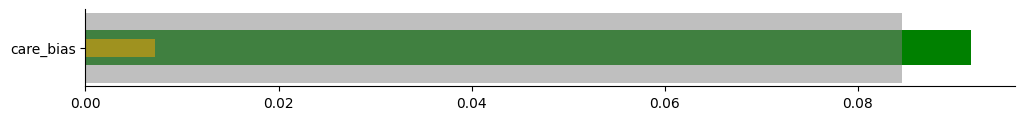
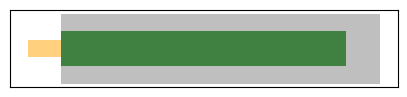
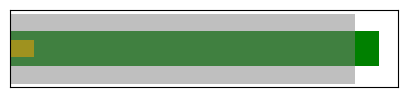
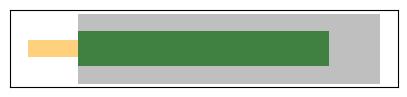
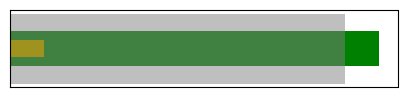
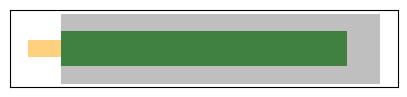
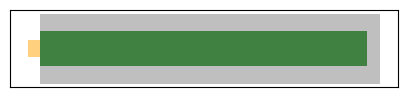
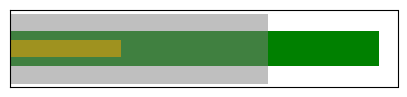
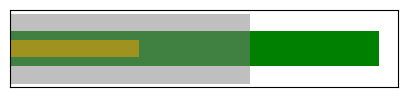
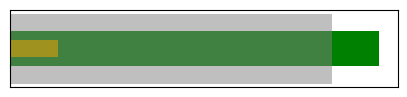
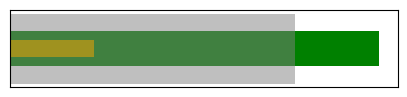

In [ ]:
plot_article_bias_shifts(article_data, class_column_names, df_background_means, 'care_bias', tokenizer)

In [ ]:
category_lists_fx.keys()

dict_keys(['Capacity and Resources', 'Crime and Punishment', 'Cultural Identity', 'Economic', 'External Regulation and Reputation', 'Fairness and Equality', 'Health and Safety', 'Legality, Constitutionality, Jurisdiction', 'Morality', 'Other', 'Policy Prescription and Evaluation', 'Political', 'Public Sentiment', 'Quality of Life', 'Security and Defense'])

In [ ]:
microframe_keys = [
    'authority_bias', 'authority_intensity', 'care_bias', 'care_intensity',
    'fairness_bias', 'fairness_intensity', 'loyalty_bias', 'loyalty_intensity',
    'sanctity_bias', 'sanctity_intensity'
]

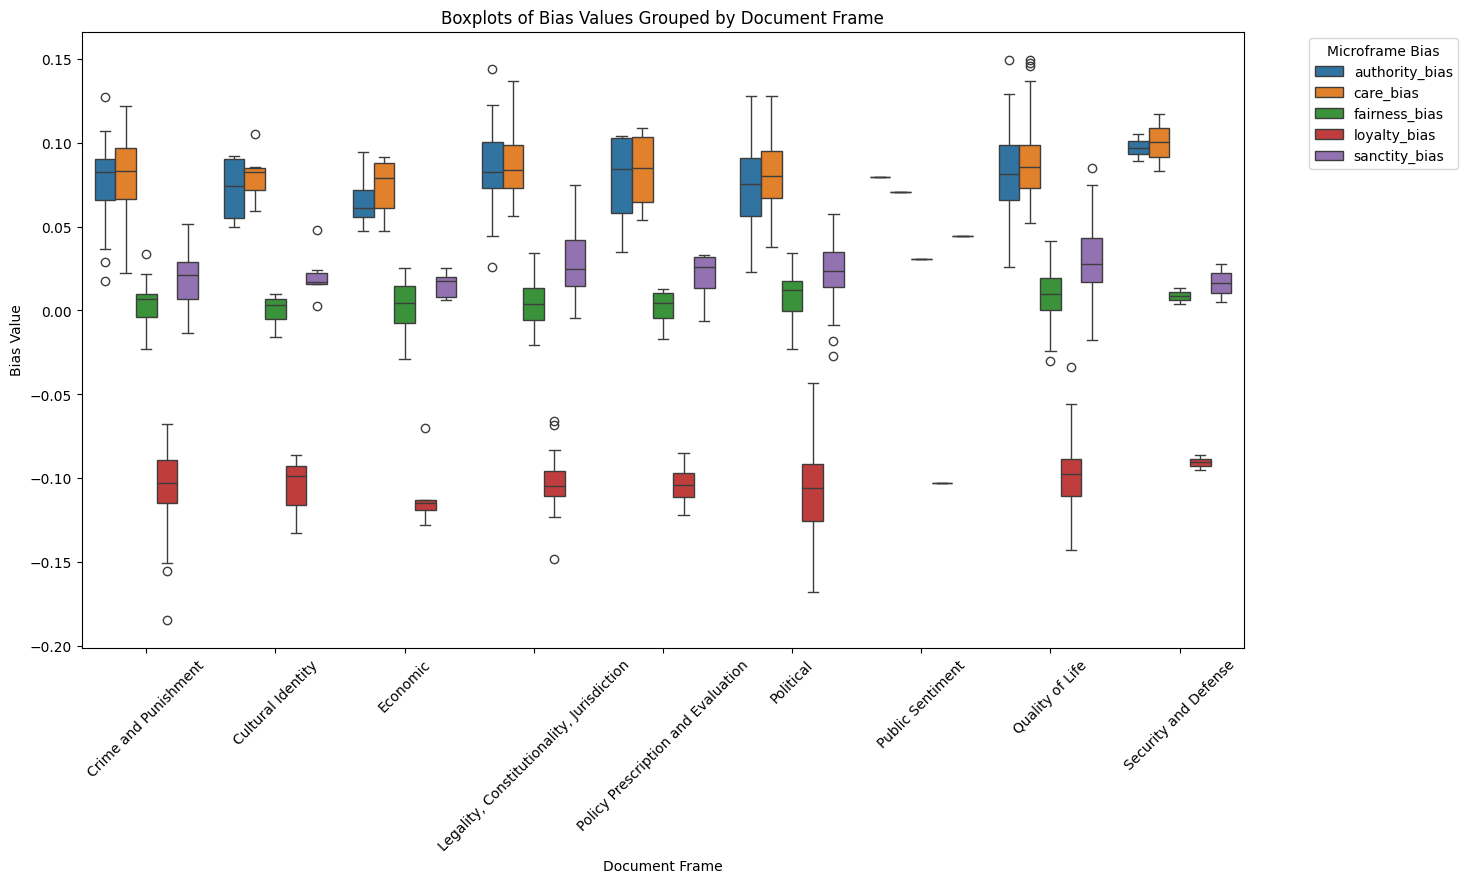

In [ ]:
import matplotlib.pyplot as plt

# Flatten the data into a DataFrame for easier manipulation
data = []

for document_frame, arrays in category_lists_fx.items():
    for arr in arrays:
        data.append([document_frame] + list(arr))

df = pd.DataFrame(data, columns=['document_frame'] + microframe_keys)

# Extracting only bias columns
bias_columns = [col for col in df.columns if 'bias' in col]
bias_df = df[['document_frame'] + bias_columns]

bias_df = bias_df[(bias_df[bias_columns] != 0).any(axis=1)]

# Generate boxplots
plt.figure(figsize=(15, 8))
bias_df_melted = bias_df.melt(id_vars=['document_frame'], var_name='microframe', value_name='value')

# Plotting
import seaborn as sns
sns.boxplot(x='document_frame', y='value', hue='microframe', data=bias_df_melted)
plt.title('Boxplots of Bias Values Grouped by Document Frame')
plt.xlabel('Document Frame')
plt.ylabel('Bias Value')
plt.legend(title='Microframe Bias', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

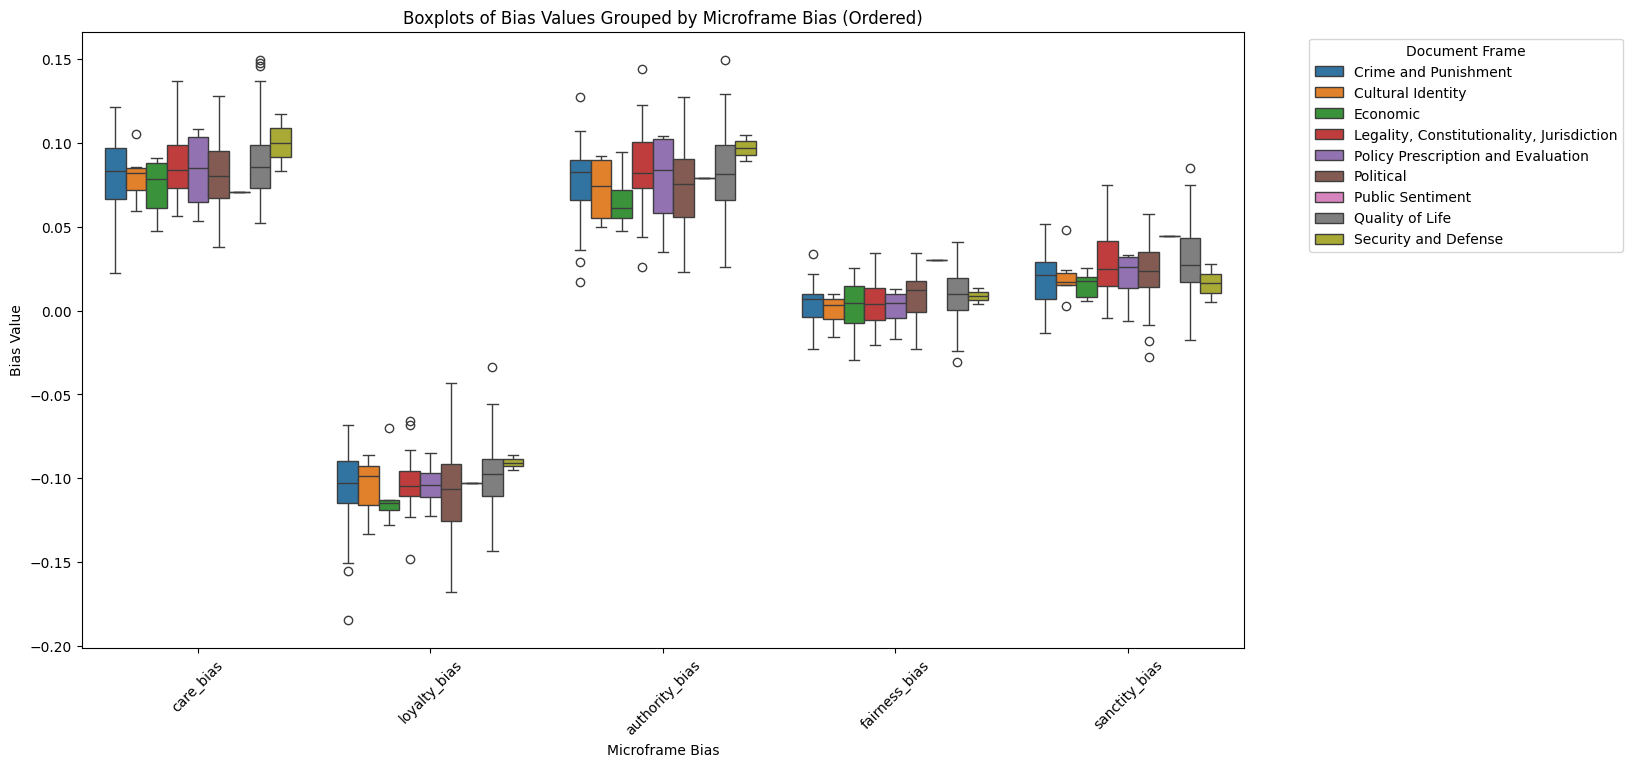

In [ ]:
# Define the desired order for microframe biases
bias_order = ['care_bias', 'loyalty_bias', 'authority_bias', 'fairness_bias', 'sanctity_bias']

# Filter the melted DataFrame to only include these biases and order them accordingly
bias_df_melted_ordered = bias_df_melted[bias_df_melted['microframe'].isin(bias_order)]
bias_df_melted_ordered['microframe'] = pd.Categorical(bias_df_melted_ordered['microframe'], categories=bias_order, ordered=True)

plt.figure(figsize=(15, 8))
sns.boxplot(x='microframe', y='value', hue='document_frame', data=bias_df_melted_ordered)
plt.title('Boxplots of Bias Values Grouped by Microframe Bias (Ordered)')
plt.xlabel('Microframe Bias')
plt.ylabel('Bias Value')
plt.legend(title='Document Frame', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


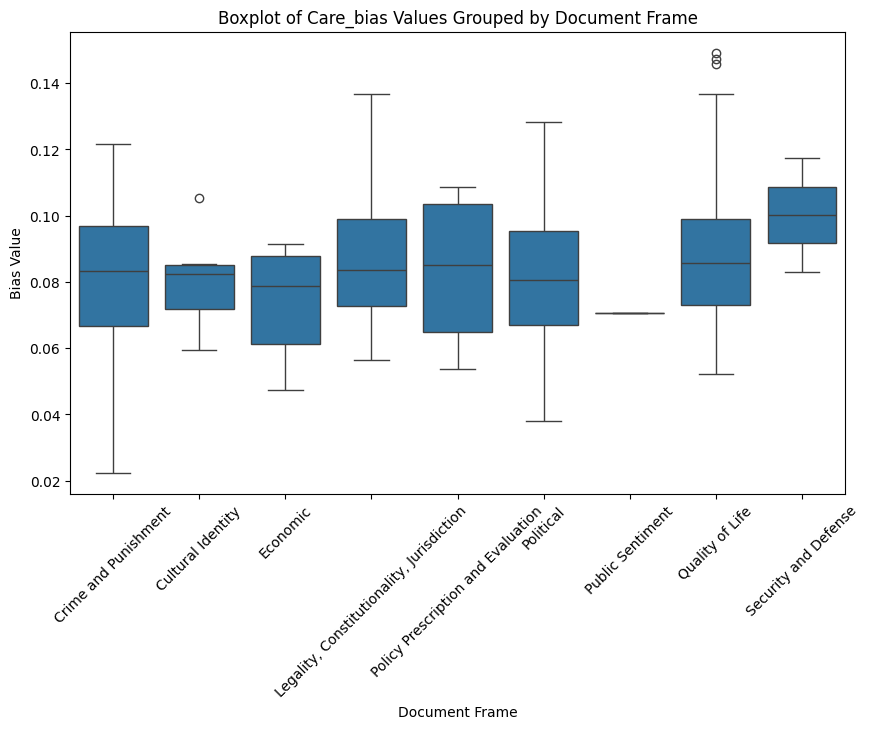

In [ ]:
# Define a function to create the boxplot for a specified microframe bias
def plot_microframe_bias(bias_name):
    filtered_df = bias_df_melted[bias_df_melted['microframe'] == bias_name]

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='document_frame', y='value', data=filtered_df)
    plt.title(f'Boxplot of {bias_name.capitalize()} Values Grouped by Document Frame')
    plt.xlabel('Document Frame')
    plt.ylabel('Bias Value')
    plt.xticks(rotation=45)
    plt.show()

# Plot only for 'care_bias'
plot_microframe_bias('care_bias')
